This tutorial demonstrates how to use the package newcoach to analyze the effect of a new coach. Here use the example dataset New_Coach_Effect.csv.
The workflow includes:
1) Data preprocessing – adding key variables (points, xGD, Diff_Elo, relative_time, post, time_post) and removing outliers with the 1.5 IQR rule
2) Exploratory plots – showing the average trends of xGD and SoT% before and after a coach change.
3) Modeling – testing OLS suitability with residual checks, and applying GLM when OLS is not appropriate.

In [1]:
from newcoach import DataPreprocessor, Modeler
from newcoach import Plotter
from newcoach import load_example
import matplotlib.pyplot as plt
# read data
df = load_example("New_Coach_Effect.csv")

# data preprocessing pipeline
dp = (
    DataPreprocessor(df)
    .add_basic_metrics()                 # points, xGD, Diff_Elo
    .add_event_time_variables(window=10) # relative_time, post, time_post
)

# flag and remove outliers 
out=dp.flag_outliers_iqr(cols=[
    "xGD", "G_minus_xG_Expected",
    "SoT_percent_Standard"
])

df_clean = dp.data.loc[~out.flags.any(axis=1)].copy() # drop outliers
# drop rows with missing key variables

df_clean = df_clean.dropna(subset=["relative_time", "post", "time_post"]).copy()

1) add_basic_metrics() for data preprocessing: add variables- points, xGD, Diff_Elo.
2) add_event_time_variables(): add time related variables to distinguish matches before or after coach change point.
3) flag_outliers_iqr(): identify all outliers based on 1.5IQR rule for all numeric variables.

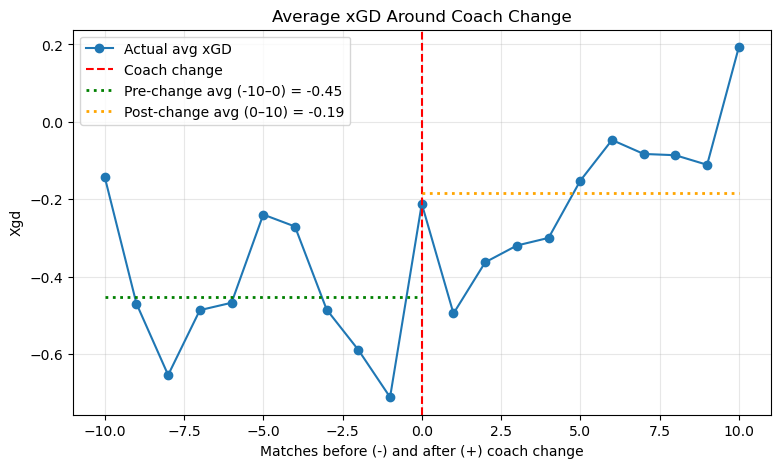

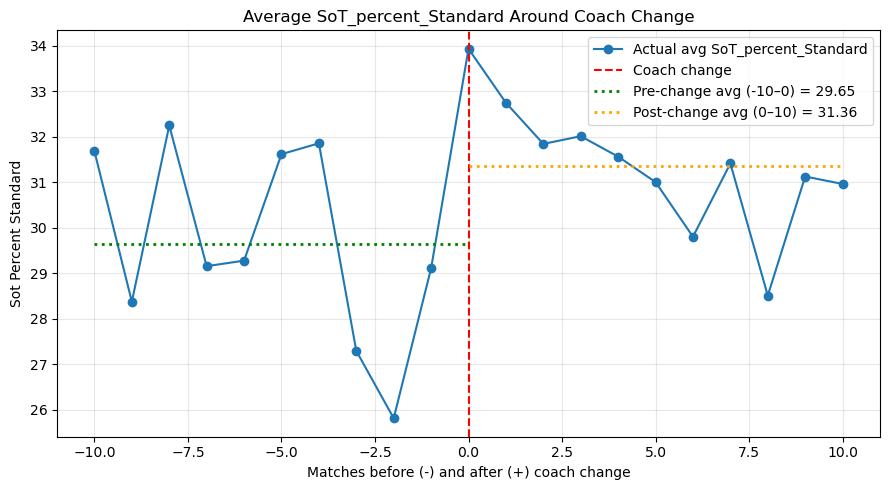

In [2]:
# average xGD and SoT% around coach change + horizontal average line
Plotter.plot_pre_post_mean(
    df=df_clean,
    value_col="xGD",
    title="Average xGD Around Coach Change"
)
Plotter.plot_pre_post_mean(
    df=df_clean,
    value_col="SoT_percent_Standard",
    title="Average SoT_percent_Standard Around Coach Change"
)
plt.tight_layout()
plt.show() 

1) plot_pre_post_mean(): Plot league-wide average values for selected variables per match around the coach-change point, along with the overall average values before and after the coach change.
2) The figure of average of xGD shows that Before the change, xGD fluctuates around the pre-change average of −0.45 and reaches its most negative value immediately prior to the switch. After the change, xGD rises to approximately 0 and slightly positive in a long run. Indicating that there is improvement of defensive.
3) The figure of average of SoT% illustrates that before the change, the average SoT% was lower at around 29.65%. After the coaching change, the average increased to 31.36%. Although fluctuations remain in individual matches, the overall post-change average is higher, indicating that the team’s shooting efficiency improved in the short term following the new coach’s appointment.

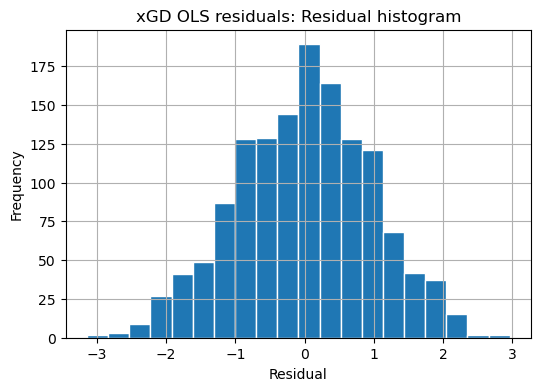

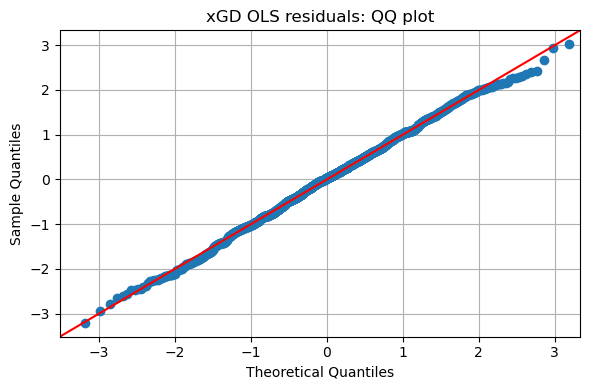

In [3]:
# modeling of OLS and check residuals and QQ plot
# set up modeler
mod = Modeler(df_clean)

# OLS：xGD
ols_xgd = mod.fit_ols(
    "xGD ~ relative_time + post + time_post + Venue_home + Diff_Elo + C(Team) - 1",
    cov_type="HC3"
)
resid_xgd = ols_xgd.resid.reset_index(drop=True)
Plotter.plot_residual_hist_and_qq(resid_xgd, title_prefix="xGD OLS residuals");
plt.tight_layout()
plt.show() 

1) Modeler(): Use OLS or GLM fitting. fit_ols: OLS model; fit_glm(): GLM model.
2) plot_residual_hist_and_qq: Plot the histogram of residuals and the QQ plot to check the validity of the OLS model.
3) The histogram shows that residuals are approximately symmetrically distributed around zero, and the Q–Q plot indicates that they follow the normality assumption reasonably well, with only minor deviations at the tails.

In [4]:
print(ols_xgd.summary())

                            OLS Regression Results                            
Dep. Variable:                    xGD   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Sep 2025   Prob (F-statistic):                nan
Time:                        23:43:57   Log-Likelihood:                -1941.1
No. Observations:                1387   AIC:                             3932.
Df Residuals:                    1362   BIC:                             4063.
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
C(Team)[Arminia]      

1) Significant decerasing before coach change point (slope=-0.0326, p-value=0.016).
2) Significant one time increasing right after the coach change point (slope=0.3416, p-value=0.002).
3) Significant slightly increasing after the coach change point (slope=0.0719, p-value approximately equal to 0).
4) Overall, the evidence points to a statistically significant immediate improvement at the change that halts the prior decline even though the improvement is tiny, with controls behaving as expected.

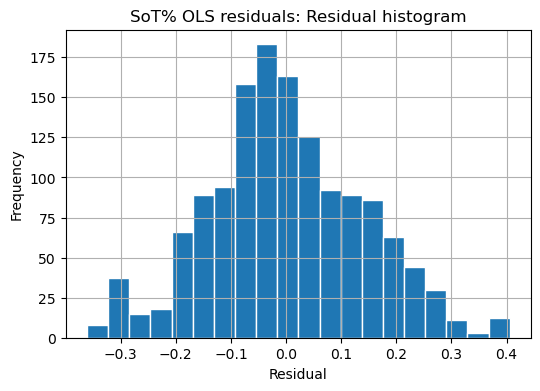

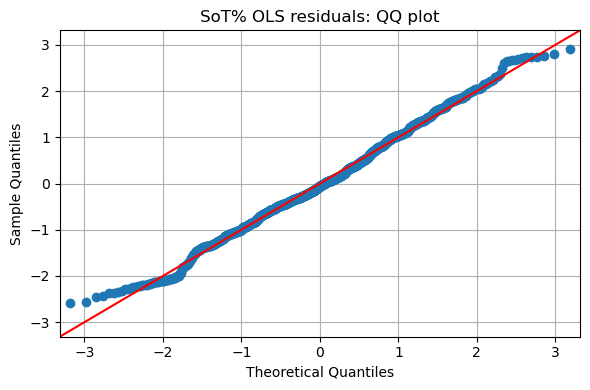

In [4]:
# OLS: SoT%
df_clean["SoT_percent"] = df_clean["SoT_percent_Standard"] / 100
ols_sot = mod.fit_ols(
    "SoT_percent ~ relative_time + post + time_post + Venue_home + Diff_Elo + C(Team) - 1",
    cov_type="HC3"
)
resid_sot = ols_sot.resid.reset_index(drop=True)
Plotter.plot_residual_hist_and_qq(resid_sot, title_prefix="SoT% OLS residuals");
plt.tight_layout()
plt.show() 

The figures show that SoT% OLS is serviceable but not ideal. The residual histogram is roughly bell-shaped, yet the QQ plot shows clear tail departures, and your outcome is a bounded proportion (0–1), which violates linear model assumptions. Binomial GLM with logit link might be more suitable.

In [6]:
# GLM: SoT%
glm_sot = mod.fit_glm(
    "SoT_percent ~ relative_time + post + time_post + Venue_home + Diff_Elo + C(Team) - 1",
    family="binomial",
    var_weights=df_clean["Sh_Standard"],
    cov_type="HC3",
)
print(glm_sot.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            SoT_percent   No. Observations:                 1387
Model:                            GLM   Df Residuals:                     1362
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7294.9
Date:                Fri, 26 Sep 2025   Deviance:                       1443.5
Time:                        23:43:58   Pearson chi2:                 1.33e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05517
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
C(Team)[Arminia]      

1) Significant decerasing before coach change point (slope=-0.021, p-value=0.012).
2) Significant one time increasing right after the coach change point (slope=0.3416, p-value=0.001).
3) Not significant: no evidence of sustained trend growth after the change.(slope=0.0719, p-value=0.271).
4) This pattern aligns with the descriptive graph, which shows a clear short-term boost in SoT% after the change but no sustained upward trajectory over time. Other controls (venue, Elo difference) were not significant.